# Text classification problem

In [ ]:
import pandas as pd
import numpy as np
import statistics
import math
import re
import os

import string
import spacy
from spacy.lang.en import English

import matplotlib.pyplot as plt
from collections import Counter

# Data Analysis and Preprocess

**Read the dataset**

In the following cell, you havt to implement a procedure to read the .txt files from the dataset provided to you and add their content to a pandas dataframe. 
Becuase our problem is text classification, please provide each text category in other cell which is the .txt files root directory's name.

Please name the text column as _text_ and category column as _category_

In [ ]:
def parse_files(path):
  ########################################
  ######### YOUR CODES GO HERE ###########
  
  folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
  dataframes = []

  for category in folders:
    category_path = os.path.join(path, category)
    for fname in sorted(os.listdir(category_path)):
      if fname.endswith('.txt'):
        with open(os.path.join(category_path, fname), 'r', encoding='unicode_escape') as f:
          content = f.read()
          dataframes.append(pd.DataFrame({'text':content, 'category':category}, index=[0]))
  df = pd.concat(dataframes, ignore_index=True)
  
  return df
  ########################################

In [ ]:
path = 'Text_dataset/raw'
df = parse_files(path)
df.head()

,text,category
0,Labour plans maternity pay rise\n\nMaternity p...,politics
1,Watchdog probes e-mail deletions\n\nThe inform...,politics
2,Hewitt decries 'career sexism'\n\nPlans to ext...,politics
3,Labour chooses Manchester\n\nThe Labour Party ...,politics
4,Brown ally rejects Budget spree\n\nChancellor ...,politics


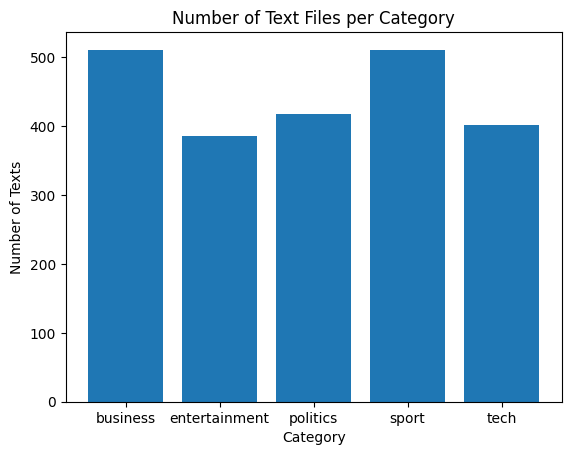

In [ ]:
'''
after preparing the dataframe, let's count the number of the text file per category
Plot them as a bar plot
'''
########################################
######### YOUR CODES GO HERE ###########

# Count the number of the text files per category
file_counts = df.groupby('category')['text'].count()

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(file_counts.index, file_counts.values)
ax.set_xlabel('Category')
ax.set_ylabel('Number of Texts')
ax.set_title('Number of Text Files per Category')
plt.show()

########################################

In order to compare the results later, we have defined a function to calculate the statistics of the dataset, and then we have called it after each preprocess step.

In [ ]:
## just run the below cell

def Amar_dataset(df, split_char=' '):
    categories = df['category'].unique()
    
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['text']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)
        
        category = row['category']
        
        all_lengths.append(l)
        per_category['lengths'][category].append(l)
    
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }

def Hist_of_statas(df_stats, n_cols=3):
  '''
  This function is used to plot the statistics claculated in the previous function
  '''
  categories = df['category'].unique()
  n_rows = math.ceil(len(categories) / n_cols)
  
  plt.figure(figsize=(15, 8))
  plt.suptitle('Distribution of lengths')
  
  # Subplot of all lengths
  plt.subplot(n_rows, n_cols, 1)
  plt.title('All categories')
  lengths = df_stats['global']['lengths']
  plt.hist(lengths, color='r')

  # Subplot of each category
  index_subplot = 2
  for c in categories:
      plt.subplot(n_rows, n_cols, index_subplot)
      plt.title('Category: %s' % c)
      
      lengths = df_stats['per_category']['lengths'][c]
      plt.hist(lengths, color='b')

      index_subplot += 1

  plt.show()

In these histograms and stats, we can see that almost all texts contain $1000$ or less words. Also, we can see that the average length is very different depending on the category.

In [ ]:
df_stats = {}

df_stats['initial'] = Amar_dataset(df)
df_stats['initial']['per_category']

,lengths,mean,stdev
politics,"[451, 380, 524, 253, 505, 348, 515, 537, 531, ...",454.973621,300.120275
tech,"[673, 384, 213, 465, 805, 630, 279, 285, 1235,...",503.695761,239.849176
sport,"[212, 145, 378, 196, 162, 147, 126, 236, 388, ...",330.262231,187.963267
business,"[422, 385, 265, 407, 266, 185, 285, 322, 230, ...",329.880392,135.919077
entertainment,"[191, 254, 193, 215, 180, 229, 360, 303, 336, ...",331.621762,261.795254


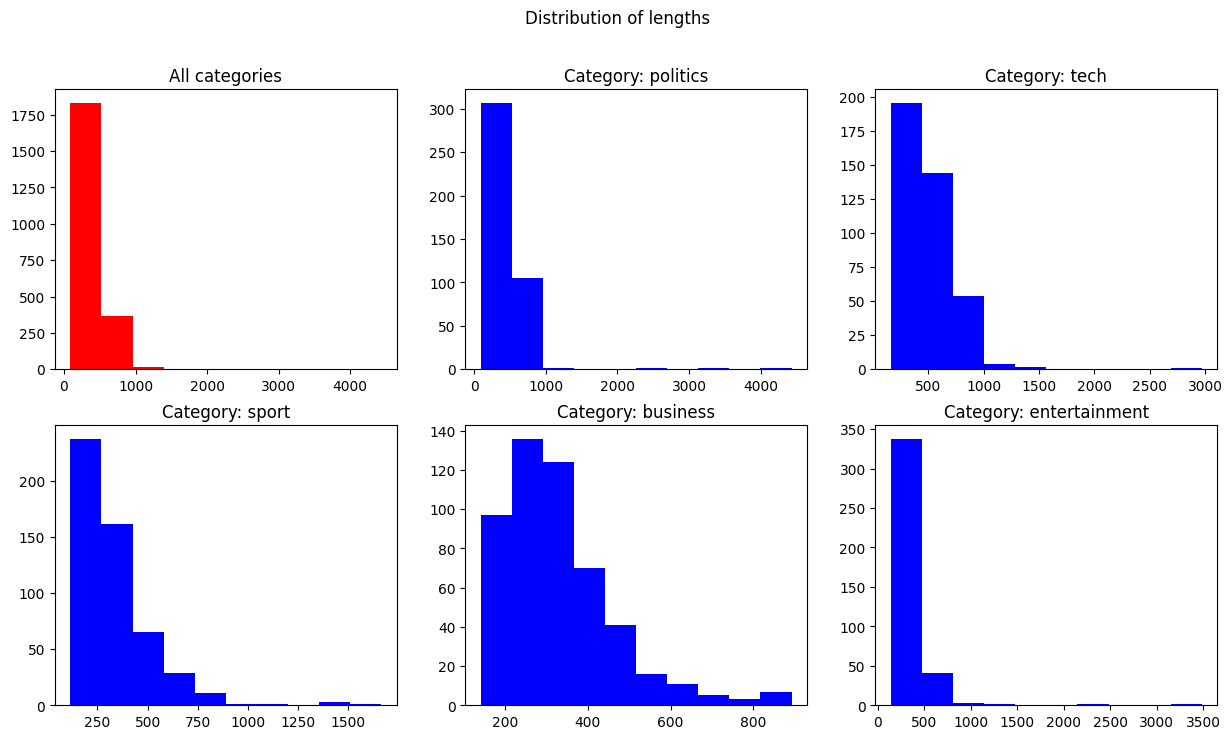

In [ ]:
Hist_of_statas(df_stats['initial'])

**Preprocess: clean characters**

Before we start to apply other techniques to clean the texts, we have removed every character which cannot be used to write words in English (this set of characters is different in other languages). Using the following function, we have removed all puntuation symbols from all texts as well as we have normalized the white spaces.

In [ ]:
'''
complete following function to iterate over the dataframe you provided before
and use the symbols in the "string.puntuation" to find all puntuations and then replace
them with ' ' in the text ypu're working on using the replace function.
Finally if there was whitespaces together please normalize them to just one space
Hint:
  https://docs.python.org/3/library/string.html#string.punctuation
  https://docs.python.org/3/library/re.html#re.sub
'''
def clean_puns(df):
    for index, row in df.iterrows():
        text = row['text']
        ########################################
        ######### YOUR CODES GO HERE ###########
        
        text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))) # Replace punctuation with space
        text = ' '.join(text.split()) # Normalize whitespace to a single space
        
        ########################################
        row['text'] = text
    
    return df

In [ ]:
df = clean_puns(df)
df.head()

,text,category
0,Labour plans maternity pay rise Maternity pay ...,politics
1,Watchdog probes e mail deletions The informati...,politics
2,Hewitt decries career sexism Plans to extend p...,politics
3,Labour chooses Manchester The Labour Party wil...,politics
4,Brown ally rejects Budget spree Chancellor Gor...,politics


In [ ]:
df_stats['char_cleaner'] = Amar_dataset(df)
df_stats['char_cleaner']['per_category']

,lengths,mean,stdev
politics,"[459, 393, 531, 254, 515, 350, 527, 543, 555, ...",461.501199,305.215664
tech,"[675, 388, 225, 470, 819, 649, 279, 300, 1250,...",513.251870,243.084510
sport,"[221, 156, 396, 196, 184, 153, 133, 238, 415, ...",341.142857,193.835379
business,"[441, 398, 271, 423, 278, 190, 291, 329, 237, ...",338.313725,138.049561
entertainment,"[193, 261, 198, 229, 189, 236, 367, 302, 339, ...",339.945596,267.569347


The average length is greater now but, why? Since we have _normalized_ the characters in the texts, there are many more white spaces now, hence apparently there are more words. For example, if we had in the original text "*U2's desire*", now we have "*U2 s desire*" (i.e. one more word has appeared due to we have tokenized using the white spaces).



```
# This is formatted as code
```

**Preprocess: Lematization**

In this notebook, we are going to do **lematization** over all the texts. To do so, we will use the library **Spacy** since it already has detailed dictionaries which the algorithm can look through to link the form back to its lemma.

We can illustrate the method with an example:

| Word | Lemma |
|---|---|
| studying | study |
| studies | study |

This process may look similar to *stemming* (which we are not going to use), but it leads to a different result.

In [ ]:
## just run the below cell

def lemmatize_dataset(df, join_char=' '):
    nlp = spacy.load("en_core_web_sm")

    for index, row in df.iterrows():
        text = row['text']
        tokens = nlp(text)
        text = [ w.lemma_.strip().lower() if w.lemma_ != "-PRON-" else w.lower_ for w in tokens ]
        row['text'] = join_char.join(text)
    
    return df

In [ ]:
df = lemmatize_dataset(df)
df.head() # Sample

,text,category
0,labour plan maternity pay rise maternity pay f...,politics
1,watchdog probe e mail deletion the information...,politics
2,hewitt decry career sexism plan to extend pay ...,politics
3,labour choose manchester the labour party will...,politics
4,brown ally reject budget spree chancellor gord...,politics


In [ ]:
df_stats['lematization'] = Amar_dataset(df)
df_stats['lematization']['per_category']

,lengths,mean,stdev
politics,"[459, 393, 532, 254, 515, 352, 527, 543, 555, ...",461.954436,305.506516
tech,"[675, 388, 225, 470, 819, 649, 279, 300, 1250,...",513.947631,243.423797
sport,"[223, 156, 399, 196, 190, 157, 138, 238, 425, ...",342.033268,194.650136
business,"[446, 398, 274, 430, 278, 190, 291, 329, 237, ...",339.345098,138.068911
entertainment,"[193, 261, 199, 229, 190, 236, 368, 302, 339, ...",340.997409,267.566780


**Preprocess: Stop words**

Stop words are a set of commonly used words in any language. For example, in English, "the", "is" and "or", would easily qualify as stop words. These words are not semantically useful in the sentences, thus it is a good idea to remove them and focus on important words instead.

In [ ]:
def clean_stops(df, join_char=' ', split_char=' '):
  '''
  please iterate over rows in the df and tokenize the texts (split them with split_char)
  Then check, tokens in the result list is not a stop word
  then convert list to a string with join_char
  '''
  stop_words = list(spacy.lang.en.stop_words.STOP_WORDS) + list(string.punctuation)
  nlp = English()
  ########################################
  ######### YOUR CODES GO HERE ###########
  cleaned_texts = []
  for index, row in df.iterrows():
      text = row['text']
      tokens = text.split(split_char)
      cleaned_tokens = [token for token in tokens if token not in stop_words]
      cleaned_text = join_char.join(cleaned_tokens)
      cleaned_texts.append(cleaned_text)
  df['text'] = cleaned_texts
  ########################################    
  return df

In [ ]:
df = clean_stops(df)
df.head() # Sample

,text,category
0,labour plan maternity pay rise maternity pay n...,politics
1,watchdog probe e mail deletion information com...,politics
2,hewitt decry career sexism plan extend pay mat...,politics
3,labour choose manchester labour party hold 200...,politics
4,brown ally reject budget spree chancellor gord...,politics


In [ ]:
df_stats['stop_words'] = Amar_dataset(df)
df_stats['stop_words']['per_category']

,lengths,mean,stdev
politics,"[223, 212, 268, 124, 261, 163, 272, 262, 310, ...",232.105516,138.141505
tech,"[343, 207, 125, 204, 414, 335, 148, 170, 614, ...",261.935162,111.661053
sport,"[119, 90, 189, 93, 121, 90, 89, 99, 250, 153, ...",174.293542,101.753161
business,"[254, 213, 155, 261, 166, 107, 153, 179, 150, ...",188.360784,71.556504
entertainment,"[105, 160, 116, 132, 119, 144, 210, 172, 181, ...",183.932642,127.966272


Now we can see that, after we have removed the stop words, the average lengths have decreased significantly.

**Preprocess: TF-IDF**

The TF-IDF value is calculated by multiplying the term frequency by the inverse document frequency. 

In the following code, we have removed the words based on the TF-IDF value. That is, we have removed from the dataset those words whose TF-IDF value is less than a certain threshold.

In [ ]:
## just run this cell


def tf_term(df, split_char=' '):
    tf = []
    for index, row in df.iterrows():
        tokens = row['text'].split(split_char)
        
        words_freqs = {}
        for w in tokens:
            words_freqs[w] = 1 if w not in words_freqs else (words_freqs[w] + 1)
        
        max_freq = max(list(words_freqs.values()))
        words_freqs = {w:(abs_freq / max_freq) for w, abs_freq in words_freqs.items()}
        
        tf.append(words_freqs)
    
    return tf


def idf_term(df, split_char=' '):
    idf = {}
    n_docs = len(df.index)
    
    count_usage = {}
    for index, row in df.iterrows():
        tokens = row['text'].split(split_char)
        
        vocabulary_in_doc = list(set(tokens))
        for w in vocabulary_in_doc:
            if w not in count_usage:
                count_usage[w] = 1
            else:
                count_usage[w] += 1
    
    for w, count in count_usage.items():            
        idf[w] = math.log(n_docs / count)
    
    return idf


def tf_idf_func(df, split_char=' '):
    tf = tf_term(df, split_char)
    idf = idf_term(df, split_char)
    
    tf_idf = []
    for index, row in df.iterrows():
        tokens = row['text'].split(split_char)
        vocabulary_in_doc = list(set(tokens))
        
        row_tf_idf = {}
        for w in vocabulary_in_doc:
            row_tf_idf[w] = tf[index][w] * idf[w]
        
        tf_idf.append(row_tf_idf)
    
    return tf_idf

def tf_idf_on_data(df, split_char=' ', join_char=' '):
    all_tf_idf = tf_idf_func(df, split_char)
    
    for doc_i, doc_tf_idf in enumerate(all_tf_idf):
        doc_tf_idf = {k: v for k, v in sorted(doc_tf_idf.items(), key=lambda item: item[1], reverse=True)}
        doc_tf_idf_values = np.array(list(doc_tf_idf.values()))

        probs = doc_tf_idf_values / sum(doc_tf_idf_values)
        
        p_value = 0
        for i, p in enumerate(probs):
            if p_value < 0.975:
                p_value += p
            else:
                break
        
        threshold = doc_tf_idf_values[i]
        
        row = df.loc[doc_i, :]
        tokens = row['text'].split(split_char)
        i = len(tokens)
        
        original_tokens = tokens.copy()
        while i >= 0:
            i -= 1
            
            w = tokens[i]
            if doc_tf_idf[w] < threshold:
                del tokens[i]
            
        
        doc_tf_idf = {k: v for k, v in sorted(doc_tf_idf.items(), key=lambda item: item[1])}        
        row['text'] = join_char.join(tokens)
    
    return df

In [ ]:
df = tf_idf_on_data(df)
df.head() # Sample

,text,category
0,labour plan maternity pay rise maternity pay n...,politics
1,watchdog probe e mail deletion information com...,politics
2,hewitt decry career sexism plan extend pay mat...,politics
3,labour choose manchester labour party hold 200...,politics
4,brown ally reject budget spree chancellor gord...,politics


We can use the implemented TF-IDF function provided in the scikit-learn
but in this notebook we implemented from scratch to see the details
you can compare the results with below function:

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [ ]:
df_stats['tf_idf'] = Amar_dataset(df)
df_stats['tf_idf']['per_category']

,lengths,mean,stdev
politics,"[209, 200, 252, 115, 244, 153, 252, 244, 286, ...",216.376499,129.999037
tech,"[321, 196, 117, 190, 384, 311, 139, 160, 566, ...",245.032419,104.894597
sport,"[112, 82, 174, 87, 107, 83, 83, 93, 225, 143, ...",160.880626,94.410552
business,"[238, 193, 147, 242, 150, 99, 142, 164, 139, 1...",174.494118,66.253954
entertainment,"[95, 144, 104, 113, 106, 131, 191, 162, 167, 1...",169.284974,120.295315


## Store parsed dataset

Finally, we have stored the dataset as a CSV file, so we could use it to train different models :)

In [ ]:
## provide your path

path = 'Text_dataset/parsed_dataset.csv'
df.to_csv(path, index_label=False)

# Training classifier

In this approach, We will train **Linear** model, which is already implemented in the library Scikit-Learn.

In [ ]:
import pickle
import seaborn as sns

from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [ ]:
def get_cats(df):
    return df['category'].unique()

In [ ]:
## provide your path

path = 'Text_dataset/parsed_dataset.csv'
df = pd.read_csv(path)
df.head()

,text,category
0,labour plan maternity pay rise maternity pay n...,politics
1,watchdog probe e mail deletion information com...,politics
2,hewitt decry career sexism plan extend pay mat...,politics
3,labour choose manchester labour party hold 200...,politics
4,brown ally reject budget spree chancellor gord...,politics


In [ ]:
X_data = df[['text']].to_numpy().reshape(-1)
Y_data = df[['category']].to_numpy().reshape(-1)

In [ ]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

n_categories = len(get_cats(df))
print('Number of categories: %d' % n_categories)

print('Loading train dataset...')

########################################
######### YOUR CODES GO HERE ###########

# split the data with a suitable ratio

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=74)
########################################

print('Done!')

Texts in dataset: 2225
Number of categories: 5
Loading train dataset...
Done!


## Create model

Here we used `GridSearch` and cross-validation to find the best parameters.

In [ ]:
'''
First of all define your params in a dictionary:
loss functions
penalties (l1 or l2)
alpha
Then define a pipeline which sequentially applys a list of transforms and a final estimator
for transformation, apply CountVectorizer and for estimator apply SGDClassifier (read the doc of the SGDClassifier)
for CountVectorizer please set strip_accents to None and disable the lowercase
Please do the search with 10-fold cross validation
finally fit the data
Hints:
  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
  https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
  https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
'''
########################################
######### YOUR CODES GO HERE ###########

# Define the hyperparameters to tune
parameters = {
    'clf__loss': ['hinge', 'log_loss', 'modified_huber'],
    'clf__penalty': ['l1', 'l2'],
    'clf__alpha': [0.0001, 0.001, 0.01, 0.1]
}

# Define the pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(strip_accents=None, lowercase=False)),
    ('clf', SGDClassifier())
])

# Perform grid search with 10-fold cross validation
clf = GridSearchCV(pipeline, parameters, cv=10, n_jobs=-1)

# Fit the data
clf.fit(X_train, Y_train)

########################################

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(lowercase=False)),
                                       ('clf', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'clf__loss': ['hinge', 'log_loss', 'modified_huber'],
                         'clf__penalty': ['l1', 'l2']})

In [ ]:
print('Best parameters set of SGDClassifier:')
print(clf.best_params_)

Best parameters set of SGDClassifier:
{'clf__alpha': 0.1, 'clf__loss': 'hinge', 'clf__penalty': 'l2'}


### SVM and Logistic Models with tuning the hyperparameters

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
# Define the hyperparameters to tune for each model
parameters_svm = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'clf__kernel': ['linear', 'rbf'],
    'clf__C': [0.01, 0.1, 1],
    'clf__gamma': [0.01, 0.1, 1]
}
parameters_logistic = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'clf__penalty': ['l2'],
    'clf__C': [0.01, 0.1, 1, 10]
}

# Define the pipeline for each model
pipeline_svm = Pipeline([
    ('vect', CountVectorizer(strip_accents=None, lowercase=False)),
    ('clf', SVC())
])
pipeline_logistic = Pipeline([
    ('vect', CountVectorizer(strip_accents=None, lowercase=False)),
    ('clf', LogisticRegression())
])

# Perform grid search with 10-fold cross validation for each model
grid_search_svm = GridSearchCV(pipeline_svm, parameters_svm, cv=10, n_jobs=-1)
grid_search_logistic = GridSearchCV(pipeline_logistic, parameters_logistic, cv=10, n_jobs=-1)

# Fit the data for each model
grid_search_svm.fit(X_train, Y_train)
grid_search_logistic.fit(X_train, Y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(lowercase=False)),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10], 'clf__penalty': ['l2'],
                         'vect__ngram_range': [(1, 1), (1, 2)]})

In [ ]:
print('Best parameters set of SVM classifier:')
print(grid_search_svm.best_params_)
print('Best parameters set of Logistic classifier:')
print(grid_search_logistic.best_params_)

Best parameters set of SVM classifier:
{'clf__C': 0.01, 'clf__gamma': 0.01, 'clf__kernel': 'linear', 'vect__ngram_range': (1, 1)}
Best parameters set of Logistic classifier:
{'clf__C': 10, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1)}


## Evaluation



In [ ]:
## just run the cell

def confusion_matrix_ploting(X_test, Y_test, model):
    Y_pred = model.predict(X_test)

    con_mat = confusion_matrix(Y_test, Y_pred)
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    label_names = list(range(len(con_mat_norm)))
    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
########################################
######### YOUR CODES GO HERE ###########

## predict the test data

Y_pred = clf.predict(X_test)
########################################

In [ ]:

########################################
######### YOUR CODES GO HERE ###########

## report the accuracy score and classification report of the model

model_accuracy = accuracy_score(Y_test, Y_pred)
classification_report = classification_report(Y_test, Y_pred)

print('Accuracy: %.4f' %model_accuracy)

print('Classification report:')
print(classification_report)
########################################

Accuracy: 0.9701
Classification report:
               precision    recall  f1-score   support

     business       0.97      0.96      0.97       162
entertainment       0.98      0.96      0.97       130
     politics       0.94      0.95      0.95       111
        sport       0.98      1.00      0.99       147
         tech       0.98      0.97      0.97       118

     accuracy                           0.97       668
    macro avg       0.97      0.97      0.97       668
 weighted avg       0.97      0.97      0.97       668



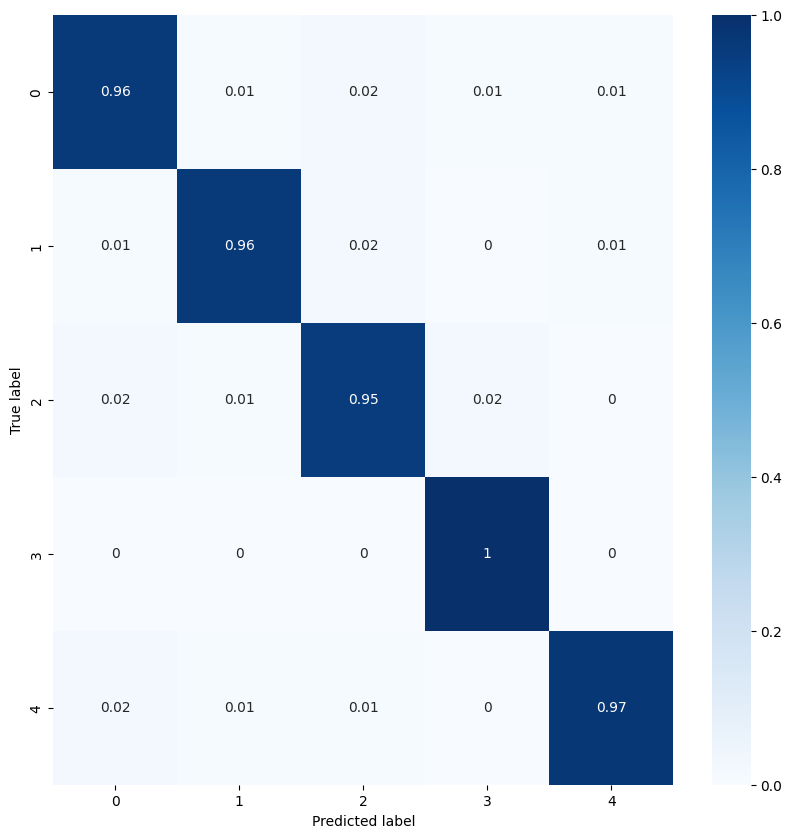

In [ ]:
## run the below cell and see your model's performance

confusion_matrix_ploting(X_test, Y_test, clf)

### Evaluation of SVM and Logistic Models

In [ ]:
## predict the test data with each model

Y_pred_svm = grid_search_svm.predict(X_test)
Y_pred_logistic = grid_search_logistic.predict(X_test)

### Accuracy score, Classification report and Confusion matrix of SVM and Logistic models

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
svm_model_accuracy = accuracy_score(Y_test, Y_pred_svm)
svm_classification_report = classification_report(Y_test, Y_pred_svm)
logistic_model_accuracy = accuracy_score(Y_test, Y_pred_logistic)
logistic_classification_report = classification_report(Y_test, Y_pred_logistic)

print('Accuracy of SVM Model: %.4f' %svm_model_accuracy)
print('Accuracy of Logistic Model: %.4f' %logistic_model_accuracy)

print('\nClassification report of SVM Model:')
print(svm_classification_report)
print('\nClassification report of Logistic Model:')
print(logistic_classification_report)

Accuracy of SVM Model: 0.9671
Accuracy of Logistic Model: 0.9686

Classification report of SVM Model:
               precision    recall  f1-score   support

     business       0.96      0.96      0.96       162
entertainment       0.99      0.95      0.97       130
     politics       0.94      0.95      0.95       111
        sport       0.97      1.00      0.98       147
         tech       0.97      0.97      0.97       118

     accuracy                           0.97       668
    macro avg       0.97      0.97      0.97       668
 weighted avg       0.97      0.97      0.97       668


Classification report of Logistic Model:
               precision    recall  f1-score   support

     business       0.97      0.96      0.97       162
entertainment       0.98      0.95      0.96       130
     politics       0.95      0.95      0.95       111
        sport       0.97      1.00      0.99       147
         tech       0.97      0.97      0.97       118

     accuracy             

Model Performance of SVM model:


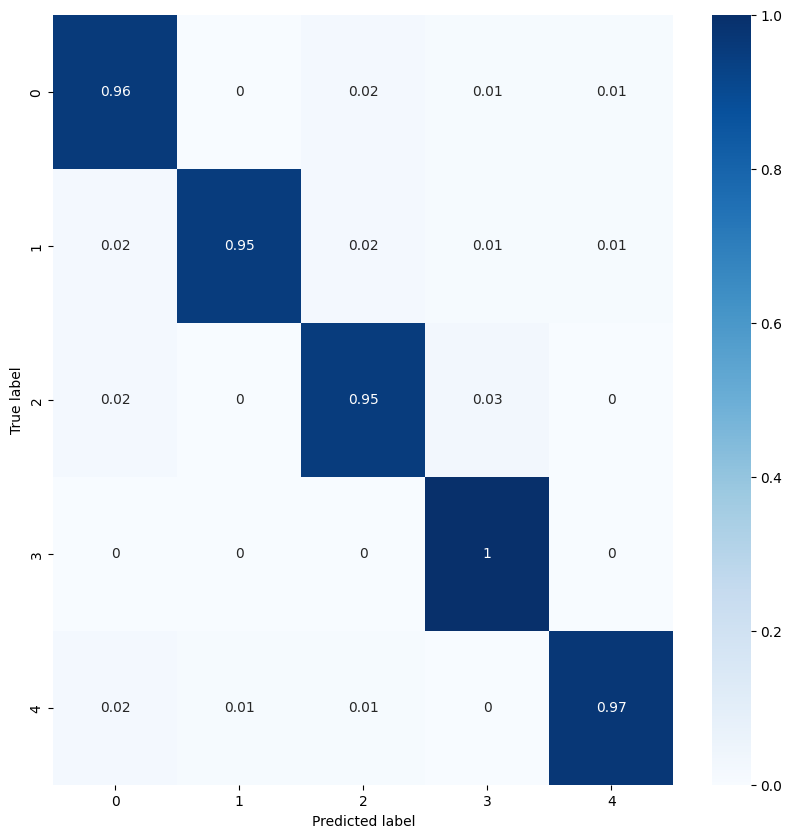

In [ ]:
# model performance of SVM model
print("Model Performance of SVM model:")
confusion_matrix_ploting(X_test, Y_test, grid_search_svm)

Model Performance of Logistic model:


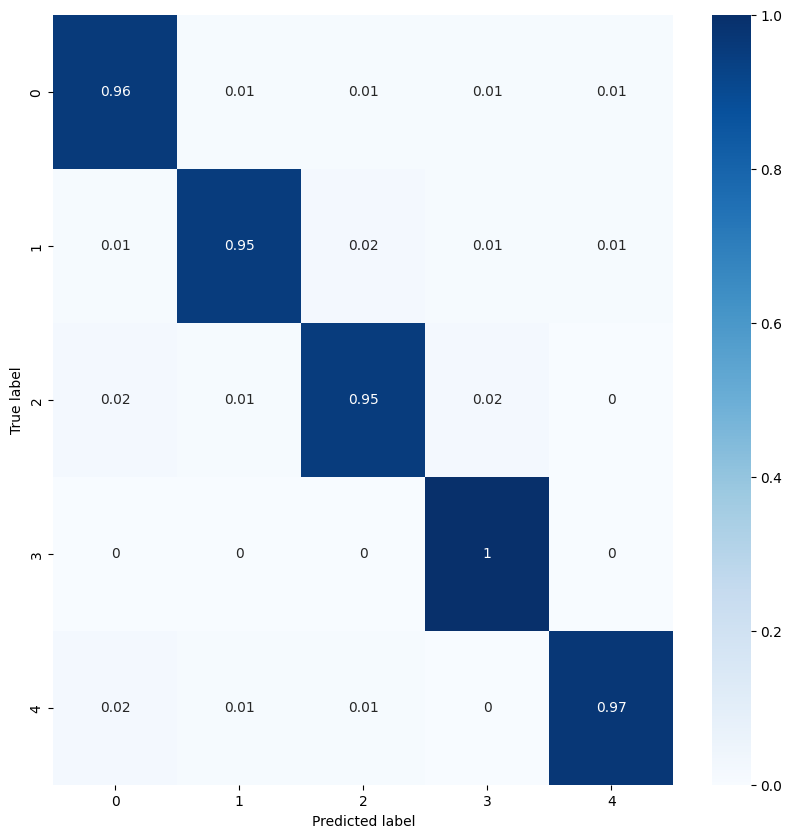

In [ ]:
# model performance of Logistic model
print("Model Performance of Logistic model:")
confusion_matrix_ploting(X_test, Y_test, grid_search_logistic)